In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.preprocessing import LabelEncoder
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard

In [2]:
df = pd.read_csv(r"C:\Users\user\Desktop\completeSpamAssassin.csv")

In [3]:
df = df.drop_duplicates(keep='first')

In [13]:
df.dropna(inplace=True)

In [4]:
df.duplicated().sum()

0

In [5]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [6]:
df['Label'].value_counts()

Label
0    4150
1    1896
Name: count, dtype: int64

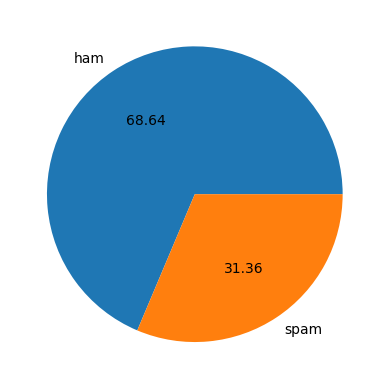

In [7]:
plt.pie(df['Label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
ps = PorterStemmer()

In [17]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [18]:
df['transformed_body'] = df['Body'].apply(transform_text)

In [19]:
texts = df["transformed_body"].tolist()

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='pre')


In [26]:
model = Sequential()
model.add(Embedding(36935, 10, input_length=max_length))
model.add(SimpleRNN(10))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [30]:
log_dir = "logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [31]:
model.fit(padded_sequences,df["Label"],epochs=5, validation_split=0.2, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/5
152/152 [==============================] - 396s 3s/step - loss: 0.6736 - accuracy: 0.6028 - val_loss: 0.5077 - val_accuracy: 1.0000
Epoch 2/5
152/152 [==============================] - 407s 3s/step - loss: 0.6708 - accuracy: 0.6081 - val_loss: 0.5048 - val_accuracy: 1.0000
Epoch 3/5
152/152 [==============================] - 409s 3s/step - loss: 0.6704 - accuracy: 0.6081 - val_loss: 0.4774 - val_accuracy: 1.0000
Epoch 4/5
152/152 [==============================] - 408s 3s/step - loss: 0.6702 - accuracy: 0.6081 - val_loss: 0.5007 - val_accuracy: 1.0000
Epoch 5/5
152/152 [==============================] - 406s 3s/step - loss: 0.6699 - accuracy: 0.6081 - val_loss: 0.4796 - val_accuracy: 1.0000


In [32]:
pickle.dump(model,open('model.pkl','wb'))